# BBC News Classification with BERT: Lab
# Solution

## Overview
As a junior data scientist at NewsInsight, a media analytics company, you've been tasked with building an automated news categorization system. Your team needs to classify incoming news articles into appropriate categories to help journalists, researchers, and business analysts quickly find relevant information.

The company receives thousands of articles daily from various sources. Currently, human editors spend significant time manually categorizing these articles, which is time-consuming and inconsistent. Your manager has asked you to develop a machine learning solution that can automatically categorize news articles into predefined categories (business, entertainment, politics, sport, tech).

This project will follow the BERT fine-tuning process you've learned:
1. Understanding data and defining requirements
2. Selecting and preparing the BERT model
3. Data preparation and tokenization
4. Model architecture design
5. Fine-tuning the model
6. Evaluation and refinement

Successfully implementing this system will significantly improve workflow efficiency, allowing editors to focus on content quality rather than manual categorization.

## Part 1: Environment Setup and Data Loading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
set_seed()

In [2]:
# Load the data from csv file
df = pd.read_csv('bbc_news_data.csv', sep='\t') 
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## Part 2: Data Exploration and Preprocessing

Explore the dataset, displaying basic information and:
- Analyze category distribution
- Check text length distribution
- Train test split data, use 75-25 split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


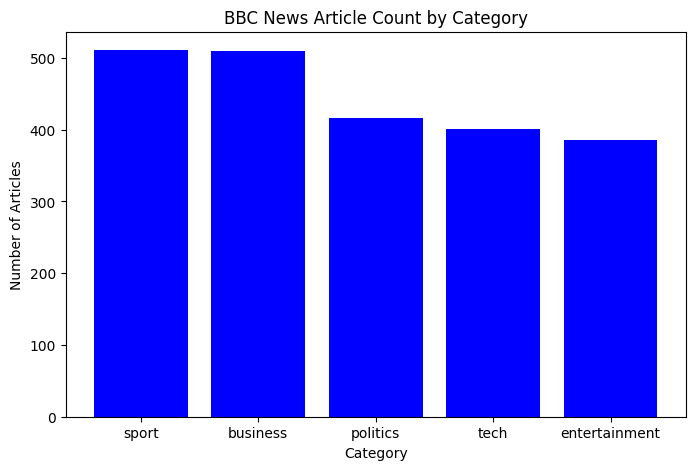

Average text length: 2232.793258426966
Min text length: 471
Max text length: 25454


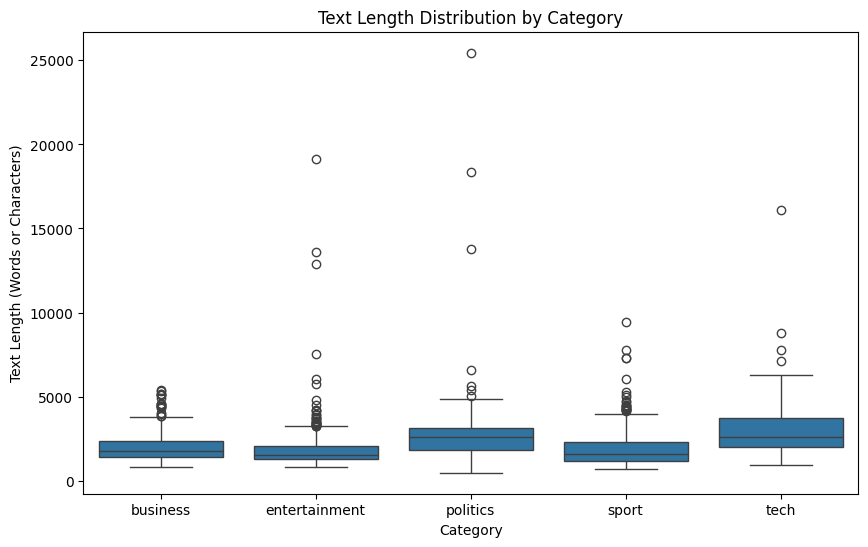

Training set size: 1335
Validation set size: 445
Test set size: 445

Category distribution in training set:
category
sport            307
business         306
politics         250
tech             240
entertainment    232
Name: count, dtype: int64

Category distribution in validation set:
category
business         102
sport            102
politics          83
tech              81
entertainment     77
Name: count, dtype: int64

Category distribution in test set:
category
business         102
sport            102
politics          84
tech              80
entertainment     77
Name: count, dtype: int64


In [7]:
# Explore the first 10 rows
df.head(10)

# Basic info and describe
df.info()
df.describe()

# Category distribution
category_counts = df['category'].value_counts()
category_counts

# Visualize category distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.title('BBC News Article Count by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

# Text length analysis
df['text_length'] = df['content'].str.len()
print(f"Average text length: {df['text_length'].mean()}")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

# Visualize text length by category
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title('Text Length Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Text Length (Words or Characters)')
plt.show()

# Check for missing values
df.isnull().sum()

# Map category labels to integers for classification
categories = list(df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
df['label'] = df['category'].map(category_mapping)

# Rename content column into text for hugging face
df.rename(columns={'content': 'text'}, inplace=True)

# Split into train, validation, and test sets, make sure to stratify based on category, keep features and target together for now
# First, create train+validation and test sets
train_val_df, test_df = train_test_split(df,test_size=0.2, stratify=df['category'], random_state=42)
# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25,  # 0.25 of 80% = 20% total
stratify=train_val_df['category'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Ensure categories are distributed properly across splits
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

## Part 3: Choose Your Model Approach
You can implement either the TensorFlow approach OR the Hugging Face approach. Delete the one you do not use.

### ------ TensorFlow Approach --------
Implement BERT with TensorFlow and TensorFlow Hub
- Import required libraries
- Select and load a BERT model
- Create datasets
 - Build model architecture
 - Fine-tune the model
 - Evaluate performance
 - Create visuals for train and validation data metrics across epochs

In [8]:
# Make sure to set legacy Keras to work with TF Hub BERT before you import
os.environ['TF_USE_LEGACY_KERAS']= '1'

# Import TensorFlow-specific libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Select and load BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_dataset(texts, labels, batch_size=32, shuffle=True):
   dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
   if shuffle:
       dataset = dataset.shuffle(len(texts))
   dataset = dataset.batch(batch_size)
   dataset = dataset.prefetch(tf.data.AUTOTUNE)
   return dataset

# Convert pandas DataFrames to TensorFlow datasets

train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

train_dataset = create_dataset(train_texts, train_labels)
val_dataset = create_dataset(val_texts, val_labels)
# Make sure to not shuffle for test data
test_dataset = create_dataset(test_texts, test_labels, shuffle=False)

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
# Build the BERT model
def build_tf_classifier_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # Preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    # BERT encoder - set trainable=True for fine-tuning
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    encoder_outputs = encoder(encoder_inputs)
    # Use the pooled output for classification
    pooled_output = encoder_outputs['pooled_output']
    
    # Add dropout for regularization
    dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
    
    # Add classification layer (for 5 categories)
    classifier_output = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(dropout)
    
    # Create model
    model = tf.keras.Model(inputs=text_input, outputs=classifier_output)
    return model

# Create model
tf_classifier_model = build_tf_classifier_model()
tf_classifier_model.summary()

# Compile the model
# Using sparse categorical crossentropy since our labels are integers
loss = tf.keras.losses.SparseCategoricalCrossentropy()
# Select accuracy as metric
metrics = ['accuracy']

# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

# Compile the model
tf_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)


# Train the model for 5 epochs (not enough epochs most likely but to save on time)
print('Fine-tuning BERT model...')
history =tf_classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [9]:
# Evaluate model on testing data
test_loss, test_accuracy = tf_classifier_model.evaluate(test_dataset)
print(f'Test accuracy (TensorFlow): {test_accuracy:.3f}')

14/14 [==============================] - 6s 393ms/step - loss: 0.2708 - accuracy: 0.9438
Test accuracy (TensorFlow): 0.944


### ------- Hugging Face Approach -------
Implement BERT with Hugging Face Transformers
- Import required libraries
- Select and load a BERT model
- Tokenize data
- Create datasets
- Fine-tune the model
- Evaluate performance

In [6]:
# Import Hugging Face libraries
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch

# Select and load tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Convert pandas DataFrames to Hugging Face datasets
train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)
test_dataset_hf = Dataset.from_pandas(test_df)

# Tokenize function (use 128 for max length)
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


# Tokenize datasets
tokenized_train = train_dataset_hf.map(tokenize_function, batched=True)
tokenized_val = val_dataset_hf.map(tokenize_function, batched=True)
tokenized_test = test_dataset_hf.map(tokenize_function, batched=True)

# Load pre-trained model with classification head
model_hf = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
# Set BERT encoder layers to not train
for param in model_hf.bert.parameters():
   param.requires_grad = False

# Define metrics computation function the returns a dictionary of scores - include at least accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Set up training arguments (train for 5 epochs - not enough to fully train but for sake of time. Set learning rate of 0.0005)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    no_cuda=True, # important for Mac users with M1+ chips
    learning_rate=0.0005)

# Initialize Trainer - include an early stopping callback with patience of 3
trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])

# Train the model
print('Fine-tuning BERT model with Hugging Face...')
trainer.train()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\spenc\anaconda3\envs\tf210\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\spenc\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

NameError: name 'train_df' is not defined

In [ ]:
# Evaluate the model
results = None
print(f"Hugging Face Model Results: {results}")

## Part 4: Model Analysis and Inference
Analyze model performance on testing data
- Create confusion matrix visualization
- Analyze misclassifications
- Identify strengths and weaknesses

### Tensorflow Model

14/14 [==============================] - 5s 379ms/step


<Figure size 1000x800 with 0 Axes>

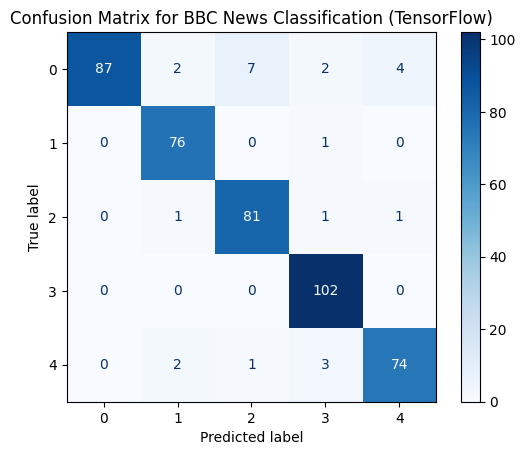


Classification Report:
               precision    recall  f1-score   support

     business       1.00      0.85      0.92       102
entertainment       0.94      0.99      0.96        77
     politics       0.91      0.96      0.94        84
        sport       0.94      1.00      0.97       102
         tech       0.94      0.93      0.93        80

     accuracy                           0.94       445
    macro avg       0.94      0.95      0.94       445
 weighted avg       0.95      0.94      0.94       445


Model Strengths and Weaknesses:

Strengths:
- Overall accuracy: 0.9438
- Best performing category: sport

Weaknesses:
- Worst performing category: business


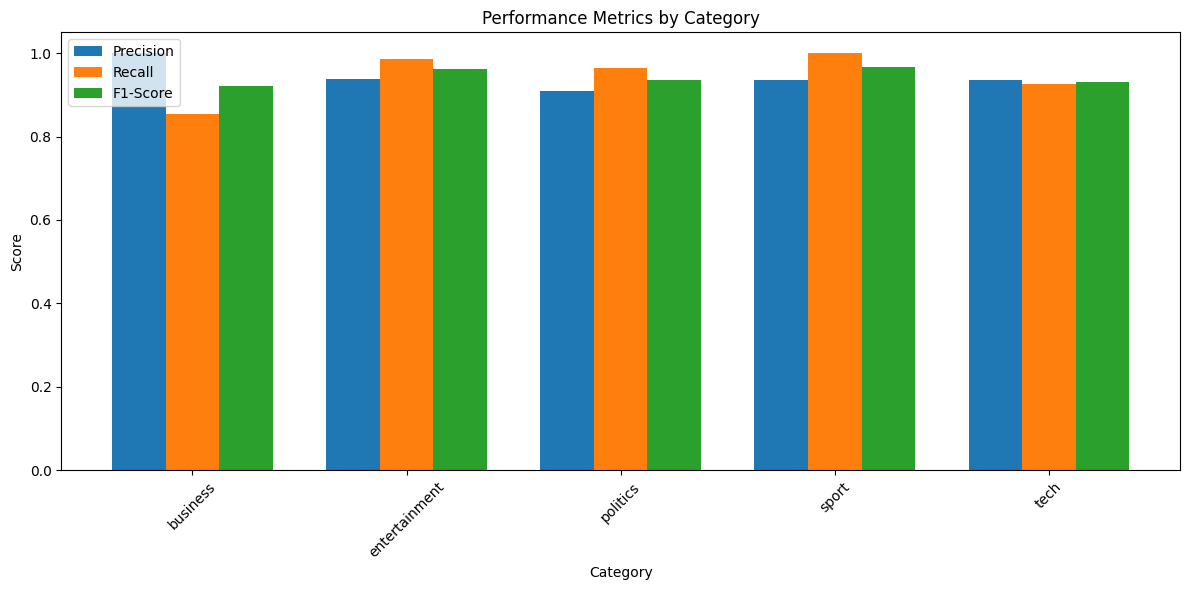

In [15]:
# Generate predictions for the test set
test_predictions = tf_classifier_model.predict(test_dataset)
y_pred = np.argmax(test_predictions, axis=1)

# Get true labels from testing data
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]

# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()

# Create classification report
report = classification_report(y_true, y_pred,)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)
# Get classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
per_class_metrics = {cat: report_dict[cat] for cat in categories}


# Find best and worst categories
best_category = max(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])
worst_category = min(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])

print(f"\nStrengths:")
print(f"- Overall accuracy: {report_dict['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices], 
        [per_class_metrics[cat]['precision'] for cat in categories], 
        width=width, label='Precision')
plt.bar(categories_indices, 
        [per_class_metrics[cat]['recall'] for cat in categories], 
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices], 
        [per_class_metrics[cat]['f1-score'] for cat in categories], 
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Create a function for model inference on new articles
def predict_article_category(text, model=tf_classifier_model):
    """
    Predict the category of a news article using the fine-tuned model.
    
    Args:
        text (str): The text of the news article
        model: The fine-tuned TensorFlow model
        
    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Make prediction
    prediction = model.predict([text])[0]
    
    # Get the predicted category and confidence
    predicted_class_id = np.argmax(prediction)
    predicted_category = categories[predicted_class_id]
    confidence = float(prediction[predicted_class_id])
    
    # Get confidence for all categories
    category_confidences = {categories[i]: float(prediction[i]) for i in range(len(categories))}
    
    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }

# Test the inference function with example articles
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    "Stock markets plummeted following the central bank's announcement of interest rate increases. Investors are concerned about the impact on economic growth.",
    "The new film starring the award-winning actress has received critical acclaim at the international film festival. Critics praised the innovative cinematography.",
    "The government announced new policies regarding digital privacy and data protection. Opposition parties have criticized the measures as inadequate."
]

print("\nTesting inference on sample articles:")
for i, article in enumerate(sample_articles):
    result = predict_article_category(article)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")


Testing inference on sample articles:
1/1 [==============================] - 0s 289ms/step

Sample 1:
Text: The tech giant announced the release of their new smartphone that features advanced AI capabilities ...
Predicted category: tech (confidence: 0.9970)
All category confidences:
  - tech: 0.9970
  - politics: 0.0010
  - entertainment: 0.0009
  - business: 0.0009
  - sport: 0.0003
1/1 [==============================] - 0s 70ms/step

Sample 2:
Text: The football team secured their victory in the final minutes with a spectacular goal. The win puts t...
Predicted category: sport (confidence: 0.9994)
All category confidences:
  - sport: 0.9994
  - entertainment: 0.0003
  - business: 0.0002
  - politics: 0.0001
  - tech: 0.0000
1/1 [==============================] - 0s 54ms/step

Sample 3:
Text: Stock markets plummeted following the central bank's announcement of interest rate increases. Invest...
Predicted category: business (confidence: 0.9826)
All category confidences:
  - business: 

### Hugging Face Model

In [ ]:
# Generate predictions for the test set
def get_predictions(trainer, dataset):
    # Run predictions with Hugging Face Trainer
    raw_predictions = None
    
    # Extract predictions and labels
    predictions = None
    labels = None
    
    return predictions, labels

y_pred, y_true = get_predictions(trainer, tokenized_test)

# Create and visualize the confusion matrix
cm = None
plt.figure(figsize=(10, 8))
disp = None
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (Hugging Face)')
plt.grid(False)
plt.show()

# Create classification report
report = None
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))


# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)
per_class_metrics = {}
None

# Find best and worst performing categories
best_category = None
worst_category = None

print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices], 
        [per_class_metrics[cat]['precision'] for cat in categories], 
        width=width, label='Precision')
plt.bar(categories_indices, 
        [per_class_metrics[cat]['recall'] for cat in categories], 
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices], 
        [per_class_metrics[cat]['f1-score'] for cat in categories], 
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a function for model inference on new articles
def predict_article_category(text, model=model_hf, tokenizer=tokenizer):
    """
    Predict the category of a news article using the fine-tuned model.
    
    Args:
        text (str): The text of the news article
        model: The fine-tuned Hugging Face model
        tokenizer: The tokenizer for the model
        
    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Tokenize inputs
    inputs = None
    
    # Get predictions
    with torch.no_grad():
        None
    
    # Convert to numpy for easier handling
    probs = None
    
    # Get the predicted category and confidence
    predicted_class_id = None
    predicted_category = categories[predicted_class_id]
    confidence = float(probs[predicted_class_id])
    
    # Get confidence for all categories
    category_confidences = {categories[i]: float(probs[i]) for i in range(len(categories))}
    
    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }

# Test the inference function with example articles
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    "Stock markets plummeted following the central bank's announcement of interest rate increases. Investors are concerned about the impact on economic growth.",
    "The new film starring the award-winning actress has received critical acclaim at the international film festival. Critics praised the innovative cinematography.",
    "The government announced new policies regarding digital privacy and data protection. Opposition parties have criticized the measures as inadequate."
]

print("\nTesting inference on sample articles:")
for i, article in enumerate(sample_articles):
    result = predict_article_category(article)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")

# Part 5: Conclusion and Discussion
Summarize your findings
- What was the final accuracy and other metrics?

The final accuracy was 94.38%
By F1scores:
Sport: 0.97
Entertainment: 0.96
Politics: 0.94
Tech: 0.93
Business: 0.92

- What categories were easiest/hardest to classify?

Sport had the highest recall (1.00!) with business having the lowest at 0.85 was the hardest.

- What challenges did you encounter?

Oh man! Do I really need to get into this lol. I had major issues with simply getting Torch installed. Outside of that I had issues with type errors in the classification report and getting stuck with how to find the best and worst categories.

- How might you improve the model further?

I could train more epochs or use other hyperparameters like learning rate or dropout rate.
